<a href="https://colab.research.google.com/github/Haebuk/kuggle/blob/main/gamestop_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 로드

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor 
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')

# 데이터 로드

In [23]:
PATH = '/content/drive/MyDrive/input/'
df = pd.read_csv(PATH + 'GME_done.csv')
df['date'] = pd.to_datetime(df['date'])
scaler = MinMaxScaler()
df['volume'] = scaler.fit_transform(df['volume'].values.reshape(-1,1))
print(df.shape)
df.head()

(2914, 3)


,date,open_price,volume
0,2010-01-04,22.070000,0.031204
1,2010-01-05,22.910000,0.024296
2,2010-01-06,23.459999,0.024552
3,2010-01-07,20.010000,0.206746
4,2010-01-08,20.639999,0.058121


## 로그 변환

In [24]:
df['open_price'] = np.log1p(df['open_price'])
df.head()

,date,open_price,volume
0,2010-01-04,3.138533,0.031204
1,2010-01-05,3.174297,0.024296
2,2010-01-06,3.197039,0.024552
3,2010-01-07,3.044999,0.206746
4,2010-01-08,3.074543,0.058121


In [25]:
df.describe()

,open_price,volume
count,2914.000000,2914.000000
mean,3.161570,0.021700
std,0.733970,0.049034
min,1.348073,0.000000
25%,2.858480,0.007970
50%,3.187385,0.012535
75%,3.610580,0.019799
max,5.942038,1.000000


# 평가지표 및 CV함수 정의

![image](https://user-images.githubusercontent.com/68543150/129554900-57c7eaf8-ef33-4da0-917b-f9aa5b4831c9.png)


In [38]:
def RMSLE(y_true, y_pred):
    # rmse를 반환(이미 로그변환이 되어있기 때문에 rmsle로 명명)
    return np.sqrt(mean_squared_error(y_true, y_pred))

def model_cv(df, model=None, fold=5, dl=False):
    """
    시계열 교차검증을 통해 평균 RMSLE를 반환하는 함수

    :params df: 데이터 프레임
    :params model: 모델
    :params fold: 폴드 수
    :params dl: 딥러닝 모델 여부

    :return pred: 예측 값
    :return mean_rmsle: 평균 RMSLE
    """
    X = df.drop('date', axis=1).values
    y = df['open_price'].values
    tscv = TimeSeriesSplit(n_splits=fold)
    rmsle_list = []
    n_iter = 1

    if dl: # 딥러닝 모델인 경우
        global time_step # window size
        time_step = 60
        
        for train_index, test_index in tscv.split(X):

            X_tr, y_tr = X[train_index], y[train_index]
            X_te, y_te = X[test_index], y[test_index]
            
            model = LSTM_Model() # LSTM 모델 클래스. 밑에서 정의함
            model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')

            X_train, y_train = [], []
            X_test, y_test = [], []
            # window size 만큼 옮겨가면서 학습/검증 셋 생성
            for i in range(time_step,len(X_tr)): # train
                X_train.append(X_tr[i-time_step:i,:])
                y_train.append(y_tr[i])
            for i in range(time_step, len(X_te)): # test
                X_test.append(X_te[i-time_step:i,:])
                y_test.append(y_te[i])
            X_train, y_train = np.array(X_train), np.array(y_train)
            X_test, y_test = np.array(X_test), np.array(y_test)
            # LSTM input shape 조건(batch_size, timestep, feature_num)에 맞게 reshape
            X_train = np.reshape(X_train, (-1,X_train.shape[1],2))
            X_test = np.reshape(X_test, (-1,X_test.shape[1],2))

            # 과적합 방지를 위해 조기종료 콜백 정의
            earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
            # 모델 학습
            model.fit(X_train, y_train, epochs=200, verbose=0, batch_size=32, callbacks=[earlystopping])
            # MSLE
            mse = model.evaluate(X_test, y_test, verbose=0)
            # 예측값
            pred = model.predict(X_test)
            # RMSLE
            rmsle = np.sqrt(mse)
            rmsle_list.append(rmsle)
            print(f"====={n_iter}FOLDS=====")
            n_iter += 1
            print(f"RMSLE: {rmsle:.4f}")
    else: # 딥러닝 모델이 아닌 경우

        for train_index, test_index in tscv.split(df):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train) # train
            pred = model.predict(X_test) # predict

            rmsle = RMSLE(y_test, pred) # RMSLE
            rmsle_list.append(rmsle)
            print(f"====={n_iter}FOLDS=====")
            print(f"RMSLE: {rmsle:.4f}")
            n_iter += 1
    mean_rmsle = np.mean(rmsle_list) # 평균 RMSLE
    print('='*10)
    print('Mean RMSLE:', mean_rmsle)
    return pred, mean_rmsle


# LightGBM

In [39]:
lgb = LGBMRegressor(learning_rate=0.1, max_depth=-1)
lgb_pred, lgb_mean_rmsle = model_cv(df=df,model=lgb)

=====1FOLDS=====
RMSLE: 0.2791
=====2FOLDS=====
RMSLE: 0.0088
=====3FOLDS=====
RMSLE: 0.0111
=====4FOLDS=====
RMSLE: 0.4664
=====5FOLDS=====
RMSLE: 0.5992
Mean RMSLE: 0.2729234071427071


- 평균 RMSLE: 0.2729
- 변동이 큰 뒤쪽에서 RMSLE가 크게 나옴

In [28]:
def pred_plot(model, pred):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], np.expm1(df['open_price']))
    plt.plot(df['date'][-len(pred):], np.expm1(pred)[-len(pred):])
    plt.legend(['original', 'predict'])
    plt.title(f'{model} Price Predict Graph')
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.show()

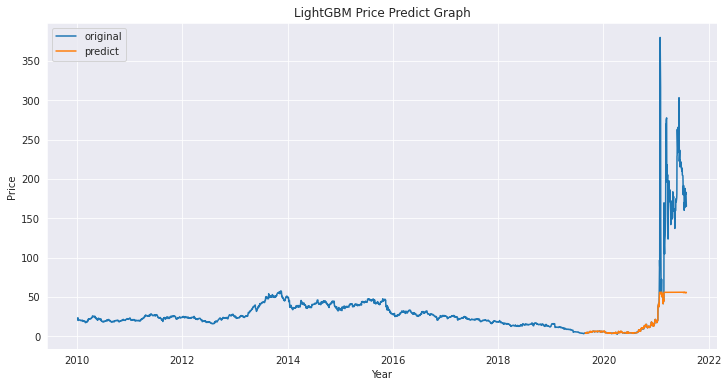

In [29]:
pred_plot('LightGBM', lgb_pred)

- 처음에 잘 맞다가 후반에는 전혀 경향을 못 따라가는 모습

# LSTM

In [40]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

class LSTM_Model(tf.keras.Model):

    def __init__(self):
        super(LSTM_Model, self).__init__()
        self.lstm1 = LSTM(50, return_sequences=True, input_shape=(time_step, 2))
        self.lstm2 = LSTM(50, return_sequences=True)
        self.lstm3 = LSTM(50)
        self.dropout = Dropout(0.4)
        self.dense = Dense(1)

    def call(self, inputs):
        x = self.lstm1(inputs)
        x = self.dropout(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.lstm3(x)
        x = self.dropout(x)
        return self.dense(x)

In [41]:
lstm_pred, lstm_mean_rmsle = model_cv(df=df,dl=True)

=====1FOLDS=====
RMSLE: 0.1768
=====2FOLDS=====
RMSLE: 0.0704
=====3FOLDS=====
RMSLE: 0.0861
=====4FOLDS=====
RMSLE: 0.1110
=====5FOLDS=====
RMSLE: 0.3570
Mean RMSLE: 0.1602563099011908


- 평균 RMSLE: 0.1603
- lightGBM보다 훨씬 좋은 결과

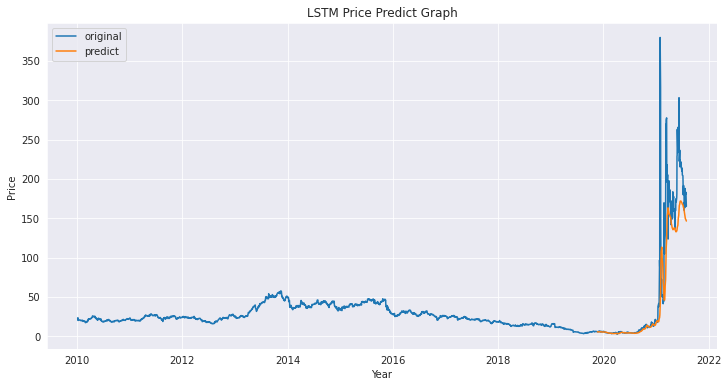

In [42]:
pred_plot('LSTM', lstm_pred)

- lightGBM보다 추세를 잘 반영했지만 약간 Underfit한 경향이 있음
- 3주차에서 HPO를 통해 성능을 향상시켜볼 예정